# Inverse model on FetchNoTask

## Instanciate and train the model

Create the environment.

In [1]:
import gym
import gym_robotics
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecTransposeImage

n_envs = 3

env = VecTransposeImage(
    make_vec_env(
        "__root__/FetchNoTask-v1",
        n_envs=n_envs,
        env_kwargs=dict(image_obs_space=True),
    )
)

Display an observation.

Creating offscreen glfw
Creating offscreen glfw


2022-06-23 11:14:05.782 Python[71635:1888200] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/z7/y_b89yb93892c6g3g2x8wk_h0000gn/T/org.python.python.savedState


Creating offscreen glfw


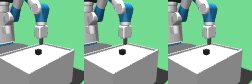

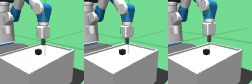

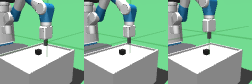

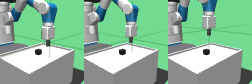

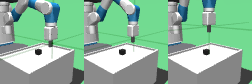

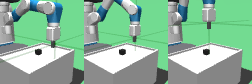

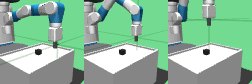

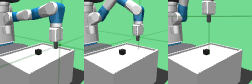

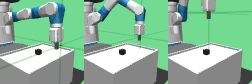

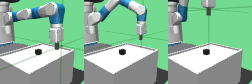

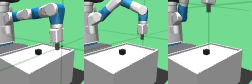

In [2]:
from PIL import Image
import numpy as np
from IPython.display import display

obs = env.reset()
img = Image.fromarray(np.hstack(np.moveaxis(obs, -3, -1)))
display(img)

actions = [
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
]
actions = np.array(actions)

for _ in range(10):
    obs, reward, done, info = env.step(actions)
    img = Image.fromarray(np.hstack(np.moveaxis(obs, -3, -1)))
    display(img)

Initilize the device.

In [3]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Create a buffer and feed it.

In [4]:
import numpy as np
from stable_baselines3.common.buffers import ReplayBuffer

from copy import deepcopy


def collect_rollouts(n, env, replay_buffer):
    num_timesteps = 0
    last_obs = env.reset()

    while num_timesteps < n:
        # Select action randomly or according to policy
        action = np.array([env.action_space.sample() for _ in range(env.num_envs)])

        # Rescale and perform action
        new_obs, rewards, dones, infos = env.step(action)

        num_timesteps += env.num_envs
        # Avoid modification by reference
        next_obs = deepcopy(new_obs)

        # As the VecEnv resets automatically, new_obs is already the
        # first observation of the next episode
        for i, done in enumerate(dones):
            if done and infos[i].get("terminal_observation") is not None:
                next_obs[i] = infos[i]["terminal_observation"]

        replay_buffer.add(
            last_obs,
            next_obs,
            action,
            rewards,
            dones,
            infos,
        )

        last_obs = new_obs


train_buffer = ReplayBuffer(
    10_000,
    env.observation_space,
    env.action_space,
    n_envs=n_envs,
    device=device,
)
test_buffer = ReplayBuffer(
    1_000,
    env.observation_space,
    env.action_space,
    n_envs=n_envs,
    device=device,
)

collect_rollouts(10_000, env, train_buffer)
collect_rollouts(1_000, env, test_buffer)

In [5]:
train_buffer.pos

1

Instanciate the model and the optimizer.

In [6]:
from lge.inverse_model import ConvInverseModel

from torch import optim

inverse_model = ConvInverseModel(action_size=env.action_space.shape[0], latent_size=16).to(device)
optimizer = optim.Adam(inverse_model.parameters(), lr=1e-3)

Train the model.

In [7]:
import torch.nn.functional as F


for epoch in range(3_000):
    # Sample
    sample = train_buffer.sample(32)
    observations = sample.observations.float() / 255
    next_observations = sample.next_observations.float() / 255
    actions = sample.actions

    # Compute the output image
    inverse_model.train()
    pred_actions = inverse_model(observations, next_observations)

    # Compute the loss
    loss = F.mse_loss(pred_actions, actions)

    # Step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        sample = test_buffer.sample(32)
        observations = sample.observations.float() / 255
        next_observations = sample.next_observations.float() / 255
        actions = sample.actions

        # Compute the output image
        inverse_model.eval()
        pred_actions = inverse_model(observations, next_observations)
        # Compute the loss
        test_loss = F.mse_loss(pred_actions, actions)
        print("epoch: {:5d}\tprediction loss: train {:.5f}, test: {:.5f} ".format(epoch, loss.item(), test_loss.item()))

epoch:     0	prediction loss: train 0.37612, test: 0.33635 
epoch:   100	prediction loss: train 0.34303, test: 0.33002 
epoch:   200	prediction loss: train 0.34357, test: 0.36672 
epoch:   300	prediction loss: train 0.34802, test: 0.34586 
epoch:   400	prediction loss: train 0.36180, test: 0.37590 
epoch:   500	prediction loss: train 0.30311, test: 0.31067 
epoch:   600	prediction loss: train 0.25166, test: 0.23672 
epoch:   700	prediction loss: train 0.20967, test: 0.18825 
epoch:   800	prediction loss: train 0.15010, test: 0.14245 
epoch:   900	prediction loss: train 0.16157, test: 0.21250 
epoch:  1000	prediction loss: train 0.15262, test: 0.19917 
epoch:  1100	prediction loss: train 0.22394, test: 0.20188 
epoch:  1200	prediction loss: train 0.18361, test: 0.17006 
epoch:  1300	prediction loss: train 0.22773, test: 0.15724 
epoch:  1400	prediction loss: train 0.22048, test: 0.17012 
epoch:  1500	prediction loss: train 0.17126, test: 0.15902 
epoch:  1600	prediction loss: train 0.17

See the result for one transition.

true action		 tensor([[ 0.9033, -0.8759,  0.2296,  0.2354]])
predicted action	 tensor([[ 1.0703, -0.8406,  0.2177, -0.0248]], grad_fn=<AddmmBackward0>)


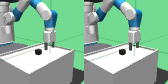

In [8]:
# Sample one transition
sample = test_buffer.sample(1)
observations = sample.observations.float() / 255
next_observations = sample.next_observations.float() / 255
actions = sample.actions

# Predict the action
inverse_model.eval()
pred_actions = inverse_model(observations, next_observations)

# See the result
print("true action\t\t", actions)
print("predicted action\t", pred_actions)


observation = sample.observations.squeeze().moveaxis(0, 2).detach().cpu().numpy()
next_observation = sample.next_observations.squeeze().moveaxis(0, 2).detach().cpu().numpy()
img = np.hstack((observation, next_observation))
img = Image.fromarray(img)
display(img)